# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
200530,71855973,Head of Brand Marketing,"Head of Brand Marketing Our client, a national...",West Midlands,West Midlands,NaN,permanent,Amoria Bond Limited,"PR, Advertising & Marketing Jobs",70k - 75k pa + benefits package,72500,jobsite.co.uk,11.191356
101685,69546325,"DevOps Engineer Linux, Agile, Java Watford (...","DevOps Engineer Linux, Agile, Java, Continuou...",Watford Hertfordshire South East,UK,NaN,permanent,People Source Consulting.,IT Jobs,65000 - 75000 per annum + bonus + car all. + p...,70000,cwjobs.co.uk,11.156265
98949,69523903,"Fitness Assistant (WCRA, West Sussex)","FITNESS ASSISTANT Storrington, West Sussex (Ch...",West Sussex,West Sussex,NaN,permanent,Impulse Leisure,Travel Jobs,6.70 per hour,12864,leisurejobs.com,9.462266


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [12]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    data[col].apply(lambda l: token_counts.update(l.split()))

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('supurb', 1)
('takin', 1)
('pupilsthey', 1)
Correct!


Text(0.5, 0, 'Counts')

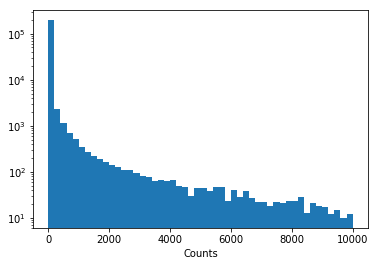

In [15]:
# Let's see how many words are there for each count

plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [20]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [t for t, c in token_counts.items() if c >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [21]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [23]:
token_to_id = dict(map(reversed, enumerate(tokens)))

In [26]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [27]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [35]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[32333 21329  2375     1     1]
 [  247  8459     1     1     1]
 [18887 19716  8061 27437  6408]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [30]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [31]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [32]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [33]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[ 9036, 14522, 25800, 32582,  1292, 29039, 17985, 18211, 21400,
         31727],
        [15340, 25764, 32582,  3927, 31765,  7427, 17295, 32582, 22554,
          7343],
        [32582, 33567,   150,  2811, 21258, 32582, 30396,  8459,   626,
         24717]], dtype=int32),
 'Log1pSalary': array([10.045031,  9.575053,  9.383033], dtype=float32),
 'Title': array([[27304,   164, 31227,  4055,     1,     1,     1,     1],
        [25323, 32629, 33457,  8459, 33690, 27769, 24741,  2486],
        [30396,  8459,     1,     1,     1,     1,     1,     1]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [34]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [36]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        r = self.conv1(h)
        r = self.pool1(r)
        r = F.relu(r)
        r = self.dense(r)
        
        return r

In [37]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [40]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
DescEncoder = TitleEncoder

In [42]:
desc_encoder = DescEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [48]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 64),
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.mixed_output = nn.Sequential(
            nn.Linear(3 * 64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 1),
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categorical_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.mixed_output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [49]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [50]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [71]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [52]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [57]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [58]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [72]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy() # [0]
        train_mae += compute_mae(reference, prediction).data.numpy() # [0]
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy() # [0]
        val_mae += compute_mae(reference, prediction).data.numpy() # [0]
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


	Loss:	1.39969
	MAE:	46054.74496



Validation:


	Loss:	1.09140
	MAE:	21881.02642



Training:


	Loss:	1.34067
	MAE:	44941.49578



Validation:


	Loss:	0.88651
	MAE:	22704.33204



Training:


	Loss:	1.20335
	MAE:	39109.02227



Validation:


	Loss:	1.07376
	MAE:	19826.70568



Training:


	Loss:	1.11892
	MAE:	35767.07002



Validation:


	Loss:	1.28478
	MAE:	20617.20970



Training:


	Loss:	1.14741
	MAE:	38534.17537



Validation:


	Loss:	1.09457
	MAE:	19896.38593



Training:


	Loss:	1.04203
	MAE:	35791.43561



Validation:


	Loss:	1.45426
	MAE:	21372.57121



Training:


	Loss:	0.99919
	MAE:	34106.46400



Validation:


	Loss:	0.50613
	MAE:	17720.11319



Training:


	Loss:	0.97279
	MAE:	32245.34418



Validation:


	Loss:	0.58564
	MAE:	17007.17044



Training:


	Loss:	0.87433
	MAE:	30247.68075



Validation:


	Loss:	0.62608
	MAE:	16506.37265



Training:


	Loss:	0.84927
	MAE:	29593.37869



Validation:


	Loss:	0.43498
	MAE:	15272.75119



Training:


	Loss:	0.81740
	MAE:	28392.28218



Validation:


	Loss:	1.36385
	MAE:	21824.95481



Training:


	Loss:	0.77302
	MAE:	28145.05249



Validation:


	Loss:	1.09250
	MAE:	20537.70519



Training:


	Loss:	0.74908
	MAE:	26835.68441



Validation:


	Loss:	0.58795
	MAE:	16496.78261



Training:


	Loss:	0.71910
	MAE:	26180.94737



Validation:


	Loss:	0.75065
	MAE:	17958.00898



Training:


	Loss:	0.68200
	MAE:	25331.61458



Validation:


	Loss:	0.30411
	MAE:	14239.87373



Training:


	Loss:	0.71763
	MAE:	26525.91492



Validation:


	Loss:	0.26188
	MAE:	12585.75405



Training:


	Loss:	0.64939
	MAE:	23929.83195



Validation:


	Loss:	0.21784
	MAE:	13119.33518



Training:


	Loss:	0.70874
	MAE:	25669.78466



Validation:


	Loss:	0.35456
	MAE:	13938.53684



Training:


	Loss:	0.63282
	MAE:	23222.37228



Validation:


	Loss:	0.22137
	MAE:	12951.09653



Training:


	Loss:	0.64706
	MAE:	24263.48534



Validation:


	Loss:	0.20171
	MAE:	11790.90842



Training:


	Loss:	0.64002
	MAE:	24264.99646



Validation:


	Loss:	0.46949
	MAE:	15464.60731



Training:


	Loss:	0.62597
	MAE:	23553.54146



Validation:


	Loss:	0.23840
	MAE:	11879.98767



Training:


	Loss:	0.59888
	MAE:	22749.21771



Validation:


	Loss:	0.30577
	MAE:	13148.19975



Training:


	Loss:	0.59018
	MAE:	23235.18686



Validation:


	Loss:	0.33891
	MAE:	13553.38988



Training:


	Loss:	0.58918
	MAE:	22076.19416



Validation:


	Loss:	0.24114
	MAE:	11910.94801



Training:


	Loss:	0.58804
	MAE:	22158.35706



Validation:


	Loss:	0.34295
	MAE:	13672.04070



Training:


	Loss:	0.59005
	MAE:	22655.85692



Validation:


	Loss:	0.18218
	MAE:	11119.47778



Training:


	Loss:	0.55596
	MAE:	21702.18289



Validation:


	Loss:	0.16377
	MAE:	10962.68240



Training:


	Loss:	0.53733
	MAE:	21201.97829



Validation:


	Loss:	0.18005
	MAE:	10873.54399



Training:


	Loss:	0.52897
	MAE:	21660.43381



Validation:


	Loss:	0.24974
	MAE:	12280.92747



Training:


	Loss:	0.51390
	MAE:	20665.16454



Validation:


	Loss:	0.25416
	MAE:	12248.33179



Training:


	Loss:	0.51503
	MAE:	20743.50057



Validation:


	Loss:	0.18253
	MAE:	12640.89731



Training:


	Loss:	0.52500
	MAE:	21221.46880



Validation:


	Loss:	0.22252
	MAE:	11671.12719



Training:


	Loss:	0.51712
	MAE:	20300.39348



Validation:


	Loss:	0.29734
	MAE:	13059.76597



Training:


	Loss:	0.49707
	MAE:	20857.04996



Validation:


	Loss:	0.21366
	MAE:	11443.99831



Training:


	Loss:	0.48954
	MAE:	19738.56684



Validation:


	Loss:	0.19036
	MAE:	11023.93639



Training:


	Loss:	0.50547
	MAE:	20815.95635



Validation:


	Loss:	0.25700
	MAE:	12607.35920



Training:


	Loss:	0.49446
	MAE:	20537.90038



Validation:


	Loss:	0.29645
	MAE:	13211.47357



Training:


	Loss:	0.48794
	MAE:	20157.54771



Validation:


	Loss:	0.15723
	MAE:	10179.81528



Training:


	Loss:	0.47601
	MAE:	20394.42146



Validation:


	Loss:	0.15127
	MAE:	10937.01022



Training:


	Loss:	0.48926
	MAE:	20568.63168



Validation:


	Loss:	0.15215
	MAE:	10180.85432



Training:


	Loss:	0.49093
	MAE:	20000.27057



Validation:


	Loss:	0.14869
	MAE:	10635.19595



Training:


	Loss:	0.45500
	MAE:	19961.43612



Validation:


	Loss:	0.28011
	MAE:	12730.47721



Training:


	Loss:	0.45879
	MAE:	19641.87006



Validation:


	Loss:	0.14013
	MAE:	9618.22376



Training:


	Loss:	0.46540
	MAE:	19302.58614



Validation:


	Loss:	0.17239
	MAE:	10430.42820



Training:


	Loss:	0.47353
	MAE:	19820.76741



Validation:


	Loss:	0.30621
	MAE:	13617.11009



Training:


	Loss:	0.45422
	MAE:	19818.68827



Validation:


	Loss:	0.14949
	MAE:	9856.98445



Training:


	Loss:	0.45645
	MAE:	19288.25793



Validation:


	Loss:	0.16994
	MAE:	10404.65749



Training:


	Loss:	0.43551
	MAE:	18978.84427



Validation:


	Loss:	0.12881
	MAE:	9675.36516



Training:


	Loss:	0.43666
	MAE:	18944.58927



Validation:


	Loss:	0.21167
	MAE:	11515.61492



Training:


	Loss:	0.43098
	MAE:	19063.89035



Validation:


	Loss:	0.16649
	MAE:	10339.75714



Training:


	Loss:	0.43107
	MAE:	18913.62099



Validation:


	Loss:	0.19241
	MAE:	10947.04657



Training:


	Loss:	0.42595
	MAE:	18810.82498



Validation:


	Loss:	0.20945
	MAE:	11432.04385



Training:


	Loss:	0.43670
	MAE:	19204.98255



Validation:


	Loss:	0.11834
	MAE:	8915.87643



Training:


	Loss:	0.42305
	MAE:	18663.78373



Validation:


	Loss:	0.15974
	MAE:	10148.33200



Training:


	Loss:	0.43013
	MAE:	18553.32541



Validation:


	Loss:	0.15304
	MAE:	10024.55650



Training:


	Loss:	0.41098
	MAE:	18011.73234



Validation:


	Loss:	0.15949
	MAE:	10108.84099



Training:


	Loss:	0.40860
	MAE:	18174.50409



Validation:


	Loss:	0.13108
	MAE:	9299.67663



Training:


	Loss:	0.41014
	MAE:	18221.28982



Validation:


	Loss:	0.12275
	MAE:	9509.86403



Training:


	Loss:	0.41194
	MAE:	18137.50295



Validation:


	Loss:	0.14289
	MAE:	9797.57143



Training:


	Loss:	0.44159
	MAE:	18818.85122



Validation:


	Loss:	0.12013
	MAE:	8950.06354



Training:


	Loss:	0.38805
	MAE:	17840.53942



Validation:


	Loss:	0.14956
	MAE:	9761.45008



Training:


	Loss:	0.40057
	MAE:	17553.65730



Validation:


	Loss:	0.21536
	MAE:	11803.55910



Training:


	Loss:	0.38982
	MAE:	18032.96544



Validation:


	Loss:	0.13543
	MAE:	9514.58996



Training:


	Loss:	0.39714
	MAE:	18365.01101



Validation:


	Loss:	0.12812
	MAE:	9271.62847



Training:


	Loss:	0.38335
	MAE:	17180.62737



Validation:


	Loss:	0.16621
	MAE:	10315.56711



Training:


	Loss:	0.38451
	MAE:	17797.16817



Validation:


	Loss:	0.11261
	MAE:	8734.32262



Training:


	Loss:	0.37093
	MAE:	17082.55190



Validation:


	Loss:	0.12178
	MAE:	9555.61200



Training:


	Loss:	0.39180
	MAE:	17589.97787



Validation:


	Loss:	0.10648
	MAE:	8681.53954



Training:


	Loss:	0.37017
	MAE:	17244.39079



Validation:


	Loss:	0.12285
	MAE:	9369.61590



Training:


	Loss:	0.36263
	MAE:	17118.85059



Validation:


	Loss:	0.10599
	MAE:	8770.90311



Training:


	Loss:	0.37072
	MAE:	17333.03599



Validation:


	Loss:	0.18309
	MAE:	12683.69322



Training:


	Loss:	0.36920
	MAE:	17227.81943



Validation:


	Loss:	0.16671
	MAE:	12208.98081



Training:


	Loss:	0.35429
	MAE:	16812.76438



Validation:


	Loss:	0.16745
	MAE:	10518.17731



Training:


	Loss:	0.36688
	MAE:	17161.71621



Validation:


	Loss:	0.11571
	MAE:	8807.15608



Training:


	Loss:	0.36316
	MAE:	16758.95432



Validation:


	Loss:	0.14643
	MAE:	9828.45325



Training:


	Loss:	0.36673
	MAE:	17232.56768



Validation:


	Loss:	0.10470
	MAE:	8604.08661



Training:


	Loss:	0.35062
	MAE:	16255.79216



Validation:


	Loss:	0.10499
	MAE:	8634.70723



Training:


	Loss:	0.34730
	MAE:	16737.32083



Validation:


	Loss:	0.14139
	MAE:	9650.38876



Training:


	Loss:	0.34279
	MAE:	16259.55122



Validation:


	Loss:	0.10556
	MAE:	8743.86151



Training:


	Loss:	0.33218
	MAE:	16095.51567



Validation:


	Loss:	0.10688
	MAE:	8472.90630



Training:


	Loss:	0.34690
	MAE:	16628.51662



Validation:


	Loss:	0.11588
	MAE:	9505.35689



Training:


	Loss:	0.34979
	MAE:	16837.47545



Validation:


	Loss:	0.10674
	MAE:	8601.36449



Training:


	Loss:	0.33845
	MAE:	16481.49535



Validation:


	Loss:	0.09744
	MAE:	8235.83754



Training:


	Loss:	0.33662
	MAE:	16553.58607



Validation:


	Loss:	0.09433
	MAE:	7998.18785



Training:


	Loss:	0.33431
	MAE:	16269.30431



Validation:


	Loss:	0.11065
	MAE:	9249.98658



Training:


	Loss:	0.32297
	MAE:	16027.57581



Validation:


	Loss:	0.10038
	MAE:	8283.35898



Training:


	Loss:	0.33766
	MAE:	15970.85119



Validation:


	Loss:	0.12395
	MAE:	8939.54050



Training:


	Loss:	0.33977
	MAE:	16496.29773



Validation:


	Loss:	0.11754
	MAE:	9419.04973



Training:


	Loss:	0.32584
	MAE:	16254.48507



Validation:


	Loss:	0.10375
	MAE:	8361.05366



Training:


	Loss:	0.32716
	MAE:	15997.06448



Validation:


	Loss:	0.10895
	MAE:	8805.43010



Training:


	Loss:	0.31716
	MAE:	16117.02764



Validation:


	Loss:	0.10403
	MAE:	8337.46745



Training:


	Loss:	0.32238
	MAE:	15986.40240



Validation:


	Loss:	0.09434
	MAE:	8064.33317



Training:


	Loss:	0.30572
	MAE:	15428.13911



Validation:


	Loss:	0.11872
	MAE:	8992.09999



Training:


	Loss:	0.31553
	MAE:	15582.00599



Validation:


	Loss:	0.10735
	MAE:	8503.03664



Training:


	Loss:	0.31915
	MAE:	15710.09326



Validation:


	Loss:	0.11076
	MAE:	9259.21213



Training:


	Loss:	0.31342
	MAE:	16062.98452



Validation:


	Loss:	0.08962
	MAE:	7845.60521



Training:


	Loss:	0.30321
	MAE:	15481.34172



Validation:


	Loss:	0.10338
	MAE:	8310.82446



Training:


	Loss:	0.31030
	MAE:	15593.06818



Validation:


	Loss:	0.09085
	MAE:	7986.78893



Training:


	Loss:	0.30562
	MAE:	15341.61462



Validation:


	Loss:	0.10233
	MAE:	8583.79518





In [70]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy() # [0]
    val_mae += compute_mae(reference, prediction).data.numpy() # [0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


	Loss:	1.17829
	MAE:	7711.17546





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    baseline_pred = <YOUR CODE>
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = <YOUR CODE>
    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    return <YOUR CODE>

In [ ]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(token_and_weights)

In [ ]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [ ]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
print("Salary (gbp):", <YOUR CODE>)

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...